## Initial hierarchical analysis

In [111]:
import cmdstanpy as csp

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [112]:
data_all = pd.read_csv("data_cut_5000.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'data_cut_5000.csv'

In [3]:
data_all.columns

Index(['template_id', 'median_z', 'mean_z', 'minchi2', 'mode_z', 'z_sigma68',
       'z_sigma', 'z_mc'],
      dtype='object')

In [71]:
N = data_all.shape[0]
# log_minchi2 = np.log(data_all["minchi2"])
median_z = data_all["median_z"]
z_sigma68 = data_all["z_sigma68"]
group_id = data_all["template_id"] + 1
num_templates = len(np.unique(group_id))

a1 = 1
b1 = 1
a2 = 1
b2 = 1
nu = 3
lambda_var = 1

In [5]:
print(np.min(group_id))
print(np.max(group_id))

1
47


In [72]:
data = {'N': N, 
        'J': num_templates,
        'z_sigma': z_sigma68,
        'median_z': median_z,
        'group_id': group_id,
        'a1': a1,
        'b1': b1,
        'a2': a2,
        'b2': b2,
        'nu': nu,
        'lambda': lambda_var,}

In [ ]:
model = csp.CmdStanModel(stan_file = 'hierarchical-regression.stan')
sample = model.sample(data = data, seed = 1, chains = 1,
                      iter_sampling = 5000, iter_warmup = 5000,
                      show_progress = False, show_console = False)

16:03:14 - cmdstanpy - INFO - CmdStan start processing
16:03:14 - cmdstanpy - INFO - Chain [1] start processing


In [ ]:
# how to save a model
sample.save_csvfiles("second-run-sigma68/model-data-50000-prior1")

# how to read a saved file
#sample = csp.from_csv("model-data-cut-5000/hierarchical-regression-20240422121707.csv")

In [54]:
alpha_list = sample.stan_variable("alpha")
beta_list = sample.stan_variable("beta")

In [40]:
print(alpha_list.shape)

(5000, 47)


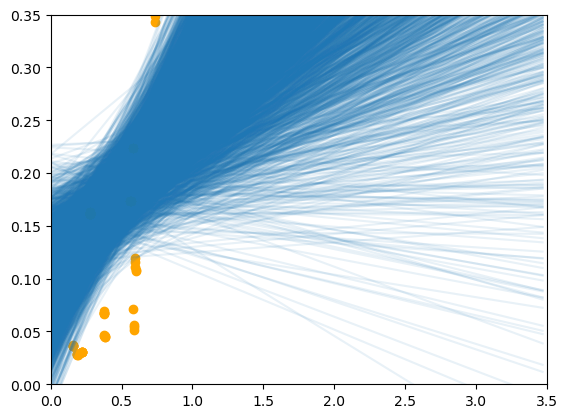

In [69]:
group_index = 41

zs = np.arange(0, np.max(median_z), np.max(median_z)/1000)
segs = []
for i in range(alpha_list.shape[0]):
    data = alpha_list[i][group_index] + beta_list[i][group_index]*zs
    segs.append(((zs[0], data[0]), (zs[-1], data[-1])))

# get first group of data
group1_sigma = np.array(z_sigma68)[np.where(group_id==group_index)]
group1_z = np.array(median_z)[np.where(group_id==group_index)]

# plot the group data

ln_coll = matplotlib.collections.LineCollection(segs, alpha=0.1)
ax = plt.gca()
ax2 = plt.scatter(group1_z, group1_sigma, color='orange')
ax.add_collection(ln_coll)
ax.set_xlim(0, 3.5)    
ax.set_ylim(0.0, 0.35)
plt.draw()

## Introducing magnitudes

In [107]:
data_mags = pd.read_csv("data_mags_50000.csv")

In [95]:
data_mags.columns

Index(['template_id', 'median_z', 'mean_z', 'minchi2', 'mode_z', 'z_sigma68',
       'z_sigma', 'z_mc', 'concentration_i', 'concentration_cal_i',
       'asymmetry_i', 'clumpiness_i', 'gini_i', 'm20_i', 'mag_sersic_i',
       'mag_cal_i', 're_sersic_i', 're_cal_i', 'n_sersic_i', 'n_sersic_cal_i',
       'ellipticity_sersic_i', 'ellipticity_sersic_cal_i'],
      dtype='object')

In [108]:
median_z = data_mags["median_z"]
mag_sersic = data_mags["mag_sersic_i"]
mag_cal = data_mags["mag_cal_i"]

In [109]:
mag_ratio = np.abs(mag_cal) / mag_sersic

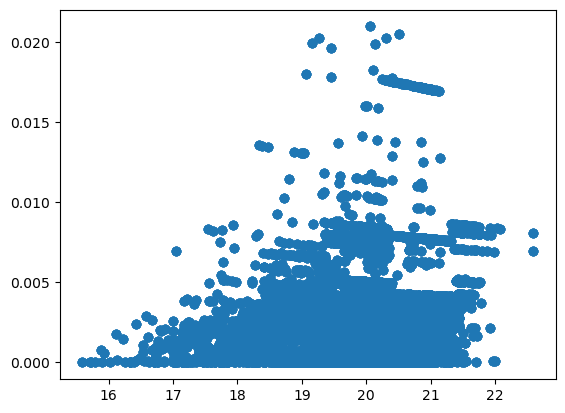

In [110]:
plt.scatter(mag_sersic, mag_ratio)